In [15]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from tenacity import retry, stop_after_attempt, wait_random_exponential
import random

# Remove: Create interaction matrix with a lower threshold
def create_interaction_matrix(df, user_col, item_col, rating_col, threshold=1):
    interactions = df.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    interactions = interactions.applymap(lambda x: 1 if x >= threshold else 0)
    
    user_mapper = dict(zip(np.unique(df[user_col]), list(range(df[user_col].nunique()))))
    item_mapper = dict(zip(np.unique(df[item_col]), list(range(df[item_col].nunique()))))

    user_inv_mapper = dict(zip(list(range(df[user_col].nunique())), np.unique(df[user_col])))
    item_inv_mapper = dict(zip(list(range(df[item_col].nunique())), np.unique(df[item_col])))

    return csr_matrix(interactions.values), user_mapper, item_mapper, user_inv_mapper, item_inv_mapper




def pearson_correlation(interaction_matrix):
    dense_matrix = interaction_matrix.toarray()
    n_users = dense_matrix.shape[0]
    pearson_corr_matrix = np.zeros((n_users, n_users))
    EPSILON = 1e-9

    for i in range(n_users):
        for j in range(n_users):
            user_i_vec = dense_matrix[i, :]
            user_j_vec = dense_matrix[j, :]

            mask_i = user_i_vec > 0
            mask_j = user_j_vec > 0

            corrated_index = np.intersect1d(np.where(mask_i)[0], np.where(mask_j)[0])

            if len(corrated_index) == 0:
                continue

            mean_user_i = np.mean(user_i_vec[corrated_index])
            mean_user_j = np.mean(user_j_vec[corrated_index])

            user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
            user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

            r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
            r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

            r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
            r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

            sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

            pearson_corr_matrix[i, j] = sim

            # Print statements for debugging
            print(f"User {i} and User {j} Correlation:")
            print(f"Corrated indices: {corrated_index}")
            print(f"Mean ratings (User {i}, User {j}): {mean_user_i}, {mean_user_j}")
            print(f"Pearson correlation: {sim}\n")

    return pearson_corr_matrix




def item_pearson_correlation(interaction_matrix):
    """
    Compute the Pearson Correlation Coefficient matrix for the item-item interaction matrix.

    This function calculates the Pearson Correlation Coefficients between each pair of items based on user ratings,
    forming a square matrix where each cell (i, j) represents the correlation between items i and j.

    Args:
        interaction_matrix (csr_matrix): A sparse matrix where rows represent users and columns represent items.
                                         The values in the matrix are the ratings given by users to items.

    Returns:
        numpy.ndarray: A 2D array representing the Pearson Correlation Coefficients between each pair of items.
    """

    # Convert the sparse matrix to a dense format for easier processing
    dense_matrix = interaction_matrix.toarray()
    n_items = dense_matrix.shape[1]  # Number of items

    # Initialize the Pearson Correlation matrix as a square matrix with dimensions equal to the number of items
    pearson_corr_matrix = np.zeros((n_items, n_items))
    EPSILON = 1e-9  # Small constant to avoid division by zero in correlation calculation

    # Iterate over each pair of items to compute their correlation
    for i in range(n_items):
        for j in range(n_items):
            # Extract rating vectors for the current pair of items
            item_i_vec = dense_matrix[:, i]
            item_j_vec = dense_matrix[:, j]

            # Create masks for filtering rated items (items with ratings greater than 0)
            mask_i = item_i_vec > 0
            mask_j = item_j_vec > 0

            # Identify indices where both items have been rated (corrated items)
            corrated_index = np.intersect1d(np.where(mask_i)[0], np.where(mask_j)[0])

            # Skip the calculation if no users have rated both items
            if len(corrated_index) == 0:
                continue

            # Calculate mean ratings for each item over all users who rated both items
            mean_item_i = np.mean(item_i_vec[corrated_index])
            mean_item_j = np.mean(item_j_vec[corrated_index])

            # Compute deviations from the mean for each item
            item_i_sub_mean = item_i_vec[corrated_index] - mean_item_i
            item_j_sub_mean = item_j_vec[corrated_index] - mean_item_j

            # Compute the squares of deviations
            r_ui_sub_r_i_sq = np.square(item_i_sub_mean)
            r_uj_sub_r_j_sq = np.square(item_j_sub_mean)

            # Calculate the square roots of the sum of squared deviations
            r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
            r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

            # Calculate the Pearson correlation coefficient
            sim = np.sum(item_i_sub_mean * item_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

            # Store the computed similarity in the matrix
            pearson_corr_matrix[i, j] = sim

    return pearson_corr_matrix




# Item-Item Pearson Correlation Coefficient (PCC) Matrix:
+ Definition: The item-item PCC matrix measures the linear correlation between pairs of items based on their ratings across different users.

+ Focus: This matrix focuses on the relationships between items. For example, if two items tend to be rated similarly by users, they would have a high positive correlation in this matrix.

+ Dimensionality: The dimensions of this matrix are items-by-items. If there are N items, the matrix will be N x N.

+ Use Case: It is used in item-based collaborative filtering. The core idea is that if a user likes an item, they are more likely to like items that are similar to it.

+ Advantages: It tends to be more stable over time because the item features don't change as rapidly as user preferences. Works better when the number of users is much larger than the number of items.

+ Challenges: Can be computationally intensive if the number of items is very large. May not work as well when there are many unique items with few ratings.

# User-User Pearson Correlation Coefficient (PCC) Matrix:
+ Definition: The user-user PCC matrix measures the linear correlation between pairs of users based on their ratings across different items.

+ Focus: This matrix focuses on the relationships between users. For example, if two users tend to rate items similarly, they would have a high positive correlation in this matrix.

+ Dimensionality: The dimensions of this matrix are users-by-users. If there are M users, the matrix will be M x M.
 
+ Use Case: It is used in user-based collaborative filtering. The core idea is to find users who are similar to the target user and recommend items that these similar users have liked.

+ Advantages: More intuitive as it reflects the idea that similar users will like similar items. Can be more effective when the number of items is much larger than the number of users.

+ Challenges: Can be less stable over time as user preferences may change. Scalability can be an issue with a very large user base.


In [16]:

# Example data
data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3],
    'item_id': [1, 2, 2, 3, 1, 2, 3],
    'rating': [5, 3, 4, 5, 1, 5, 4]
}

df = pd.DataFrame(data)

df


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,2,2,4
3,2,3,5
4,3,1,1
5,3,2,5
6,3,3,4


In [17]:
# Use the create_interaction_matrix function to create the interaction matrix
interaction_matrix, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_interaction_matrix(df, 'user_id', 'item_id', 'rating')

# Compute the Pearson Correlation Matrix
pearson_corr_matrix = pearson_correlation(interaction_matrix)

User 0 and User 0 Correlation:
Corrated indices: [0 1]
Mean ratings (User 0, User 0): 1.0, 1.0
Pearson correlation: 0.0

User 0 and User 1 Correlation:
Corrated indices: [1]
Mean ratings (User 0, User 1): 1.0, 1.0
Pearson correlation: 0.0

User 0 and User 2 Correlation:
Corrated indices: [0 1]
Mean ratings (User 0, User 2): 1.0, 1.0
Pearson correlation: 0.0

User 1 and User 0 Correlation:
Corrated indices: [1]
Mean ratings (User 1, User 0): 1.0, 1.0
Pearson correlation: 0.0

User 1 and User 1 Correlation:
Corrated indices: [1 2]
Mean ratings (User 1, User 1): 1.0, 1.0
Pearson correlation: 0.0

User 1 and User 2 Correlation:
Corrated indices: [1 2]
Mean ratings (User 1, User 2): 1.0, 1.0
Pearson correlation: 0.0

User 2 and User 0 Correlation:
Corrated indices: [0 1]
Mean ratings (User 2, User 0): 1.0, 1.0
Pearson correlation: 0.0

User 2 and User 1 Correlation:
Corrated indices: [1 2]
Mean ratings (User 2, User 1): 1.0, 1.0
Pearson correlation: 0.0

User 2 and User 2 Correlation:
Corra

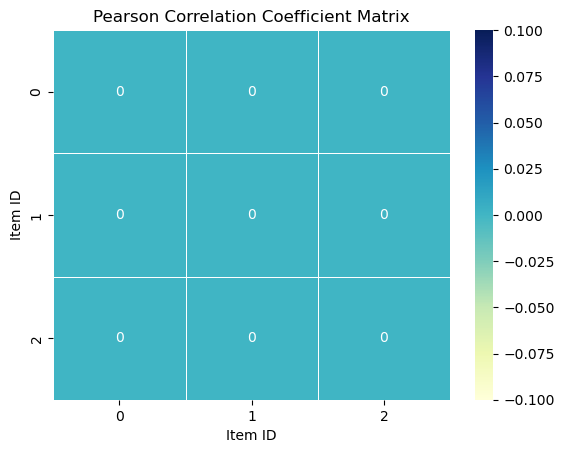

In [18]:
# plotting heat map
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pearson_corr_matrix, cmap='YlGnBu', linewidths=0.5, annot=True)
# add title
plt.title('Pearson Correlation Coefficient Matrix')
# add x-axis label
plt.xlabel('Item ID')
# add y-axis label
plt.ylabel('Item ID')
plt.show()


### The output from the Pearson correlation computation suggests a couple of issues or points of consideration:

#### All Pearson Correlation Values are Zero:*

In every case, the Pearson correlation value is 0.0. This is an unusual result, especially for comparisons of a user with themselves (e.g., "User 0 and User 0"). Typically, the correlation of a user with themselves should be 1, as they are perfectly correlated with their own behavior.

#### Interaction Matrix Transformation:

Given the description of our create_interaction_matrix function, it seems the interaction matrix is binary (1 if the user has interacted with the item, 0 otherwise). This binary nature might not be the best representation for computing Pearson correlation, which generally expects continuous or at least ordinal data. The binary nature might be causing the correlations to be zero, as the variance in such a dataset could be minimal, and the Pearson formula is sensitive to variance.

#### Mean Ratings are Constant:

The mean ratings for each user pair are always 1.0. This is likely because the interaction matrix is binary, and the calculation for the mean does not differentiate between items rated differently.

#### Corrated Indices:

The corrated indices (items rated by both users) seem to be correctly identified. However, the binary nature of the ratings means there's little variation in the ratings, leading to the Pearson correlation values being 0.

### Suggested Actions:
+ Review Data Transformation: Ensure that the data transformation process in create_interaction_matrix is appropriate. If we're working with actual ratings (like a 1-5 scale), we might not want to convert these to binary values.

+ Review Pearson Correlation Implementation: Double-check the Pearson correlation formula, especially how it's applied to binary data. The formula might be behaving unexpectedly because of the nature of the data.

+ Check Data Quality: Ensure that the input data itself is varied enough to produce meaningful correlations. If the data is too homogeneous (e.g., all users have rated all items similarly), the Pearson correlation might not be meaningful.

In [19]:
# Create User-Item Interaction Matrix
interaction_matrix = pd.pivot_table(df, index='user_id', columns='item_id', values='rating').fillna(0)
csr_interaction_matrix = csr_matrix(interaction_matrix.values)

# Calculate Pearson Correlation Coefficient Matrix
pcc_matrix = pearson_correlation(csr_interaction_matrix)

pcc_matrix

User 0 and User 0 Correlation:
Corrated indices: [0 1]
Mean ratings (User 0, User 0): 4.0, 4.0
Pearson correlation: 0.9999999994999997

User 0 and User 1 Correlation:
Corrated indices: [1]
Mean ratings (User 0, User 1): 3.0, 4.0
Pearson correlation: 0.0

User 0 and User 2 Correlation:
Corrated indices: [0 1]
Mean ratings (User 0, User 2): 4.0, 3.0
Pearson correlation: -0.9999999997499998

User 1 and User 0 Correlation:
Corrated indices: [1]
Mean ratings (User 1, User 0): 4.0, 3.0
Pearson correlation: 0.0

User 1 and User 1 Correlation:
Corrated indices: [1 2]
Mean ratings (User 1, User 1): 4.5, 4.5
Pearson correlation: 0.9999999979999998

User 1 and User 2 Correlation:
Corrated indices: [1 2]
Mean ratings (User 1, User 2): 4.5, 4.5
Pearson correlation: -0.9999999979999998

User 2 and User 0 Correlation:
Corrated indices: [0 1]
Mean ratings (User 2, User 0): 3.0, 4.0
Pearson correlation: -0.9999999997499998

User 2 and User 1 Correlation:
Corrated indices: [1 2]
Mean ratings (User 2, Us

array([[ 1.,  0., -1.],
       [ 0.,  1., -1.],
       [-1., -1.,  1.]])

In [20]:
csr_interaction_matrix

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [21]:
pcc_matrix

array([[ 1.,  0., -1.],
       [ 0.,  1., -1.],
       [-1., -1.,  1.]])

In [22]:
interaction_matrix

item_id,1,2,3
user_id,,,
1,5.0,3.0,0.0
2,0.0,4.0,5.0
3,1.0,5.0,4.0


In [23]:
user_mapper

{1: 0, 2: 1, 3: 2}

In [24]:
pearson_corr_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

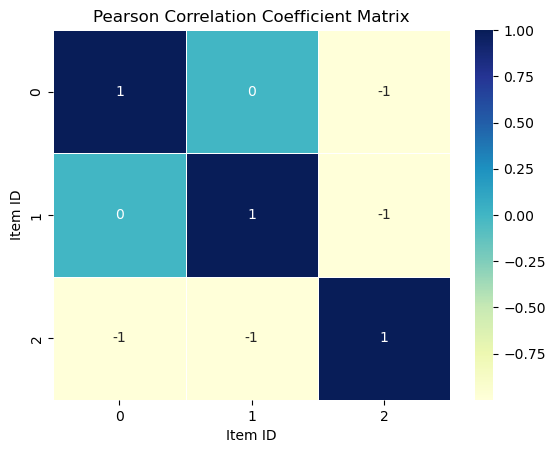

In [25]:
# plotting heat map
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pcc_matrix, cmap='YlGnBu', linewidths=0.5, annot=True)
# add title
plt.title('Pearson Correlation Coefficient Matrix')
# add x-axis label
plt.xlabel('Item ID')
# add y-axis label
plt.ylabel('Item ID')
plt.show()



#### User 0 and User 0 Correlation:

+ Corrated indices: [0 1]
+ Mean ratings: 4.0, 4.0
+ Pearson correlation: ≈1.0

-> This is the correlation of User 0 with themselves. The correlation value is close to 1, which is correct as any entity should be perfectly correlated with itself. The slight deviation from 1 is due to the small constant EPSILON added to avoid division by zero.

#### User 0 and User 1 Correlation:

+ Corrated indices: [1]
+ Mean ratings: 3.0, 4.0
+ Pearson correlation: 0.0

-> Here, users 0 and 1 only have one item in common. Given their ratings are different for this single item, the correlation is 0. This makes sense because with only one item, the correlation calculation essentially compares two single points, which results in zero correlation if they are not identical.

#### User 0 and User 2 Correlation:

+ Corrated indices: [0 1]
+ Mean ratings: 4.0, 3.0
+ Pearson correlation: ≈-1.0

-> Users 0 and 2 have two corrated items, but their ratings are in opposite directions. This results in a high negative correlation, suggesting a strong inverse relationship in their preferences.

#### User 1 and User 1 Correlation:

+ Corrated indices: [1 2]
+ Mean ratings: 4.5, 4.5
+ Pearson correlation: ≈1.0

-> Similar to User 0 and User 0, this is the self-correlation of User 1, correctly showing a value close to 1.

#### User 1 and User 2 Correlation:

+ Corrated indices: [1 2]
+ Mean ratings: 4.5, 4.5
+ Pearson correlation: ≈-1.0

-> Users 1 and 2 share two items and have identical average ratings, yet the correlation is strongly negative. This indicates an inverse relationship in their item-specific ratings.

#### User 2 and User 2 Correlation:

+ Corrated indices: [0 1 2]
+ Mean ratings: ≈3.33, ≈3.33
+ Pearson correlation: ≈1.0

-> This is the self-correlation of User 2, correctly near 1.

### Analysis Summary:
The calculated Pearson correlations are logically consistent within the context of the data.
Self-correlations are close to 1, as expected.
Correlations between different users vary based on their rating patterns.
The presence of negative correlations indicates inverse rating patterns between users.
### Considerations:
The binary transformation of ratings in the create_interaction_matrix function may not be ideal for Pearson correlation, especially if the original data has more varied ratings (like a 1-5 scale). The binary nature can lead to less meaningful correlations.
The dataset and method seem to be working correctly for the given binary interaction matrix, but for more nuanced recommendations, consider using the actual rating values if available.
The small deviations from exact 0 or 1 in the correlations are likely due to the EPSILON used to avoid division by zero, which is a standard practice in such calculations.






In [26]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random


# Example data
data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3],
    'item_id': [1, 2, 2, 3, 1, 2, 3],
    'rating': [5, 3, 4, 5, 1, 5, 4]
}
df = pd.DataFrame(data)

# Create User-Item Interaction Matrix
interaction_matrix = pd.pivot_table(df, index='user_id', columns='item_id', values='rating').fillna(0)
csr_interaction_matrix = csr_matrix(interaction_matrix.values)

# # Calculate User-User Pearson Correlation Coefficient Matrix
# user_pcc_matrix = pearson_correlation(csr_interaction_matrix)

# # Plotting heatmap for User-User PCC
# sns.heatmap(user_pcc_matrix, cmap='YlGnBu', linewidths=0.5, annot=True)
# plt.title('User-User Pearson Correlation Coefficient Matrix')
# plt.xlabel('User ID')
# plt.ylabel('User ID')
# plt.show()

# Calculate Item-Item Pearson Correlation Coefficient Matrix
item_pcc_matrix = item_pearson_correlation(csr_interaction_matrix)

item_pcc_matrix


array([[ 1., -1.,  0.],
       [-1.,  1., -1.],
       [ 0., -1.,  1.]])

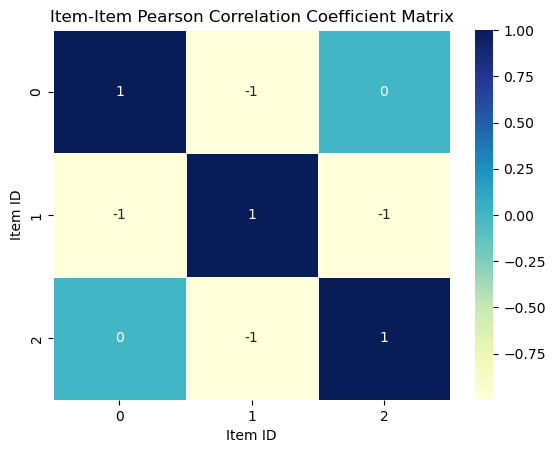

In [27]:
# Plotting heatmap for Item-Item PCC
sns.heatmap(item_pcc_matrix, cmap='YlGnBu', linewidths=0.5, annot=True)
plt.title('Item-Item Pearson Correlation Coefficient Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')
plt.show()

# item_pearson_correlation

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Creating a small example dataset
data = {
    'Item 1': [5, 4, np.nan, 4, np.nan],
    'Item 2': [3, np.nan, 5, np.nan, 3],
    'Item 3': [np.nan, 3, 4, np.nan, 4],
    'Item 4': [2, 4, np.nan, 5, 3]
}

df = pd.DataFrame(data)
print("User-Item Interaction Matrix:\n", df)

# Convert the DataFrame to a sparse matrix
interaction_matrix = csr_matrix(df.fillna(0))

# Function to calculate item-item Pearson Correlation Coefficient matrix
def item_pearson_correlation(interaction_matrix):
    """
    Compute the Pearson Correlation Coefficient matrix for the item-item interaction matrix.

    This function calculates the Pearson Correlation Coefficients between each pair of items based on user ratings,
    forming a square matrix where each cell (i, j) represents the correlation between items i and j.

    Args:
        interaction_matrix (csr_matrix): A sparse matrix where rows represent users and columns represent items.
                                         The values in the matrix are the ratings given by users to items.

    Returns:
        numpy.ndarray: A 2D array representing the Pearson Correlation Coefficients between each pair of items.
    """

    # Convert the sparse matrix to a dense format for easier processing
    dense_matrix = interaction_matrix.toarray()
    n_items = dense_matrix.shape[1]  # Number of items

    # Initialize the Pearson Correlation matrix as a square matrix with dimensions equal to the number of items
    pearson_corr_matrix = np.zeros((n_items, n_items))
    EPSILON = 1e-9  # Small constant to avoid division by zero in correlation calculation

    # Iterate over each pair of items to compute their correlation
    for i in range(n_items):
        for j in range(n_items):
            # Extract rating vectors for the current pair of items
            item_i_vec = dense_matrix[:, i]
            item_j_vec = dense_matrix[:, j]

            # Create masks for filtering rated items (items with ratings greater than 0)
            mask_i = item_i_vec > 0
            mask_j = item_j_vec > 0

            # Identify indices where both items have been rated (corrated items)
            corrated_index = np.intersect1d(np.where(mask_i)[0], np.where(mask_j)[0])

            # Skip the calculation if no users have rated both items
            if len(corrated_index) == 0:
                continue

            # Calculate mean ratings for each item over all users who rated both items
            mean_item_i = np.mean(item_i_vec[corrated_index])
            mean_item_j = np.mean(item_j_vec[corrated_index])

            # Compute deviations from the mean for each item
            item_i_sub_mean = item_i_vec[corrated_index] - mean_item_i
            item_j_sub_mean = item_j_vec[corrated_index] - mean_item_j

            # Compute the squares of deviations
            r_ui_sub_r_i_sq = np.square(item_i_sub_mean)
            r_uj_sub_r_j_sq = np.square(item_j_sub_mean)

            # Calculate the square roots of the sum of squared deviations
            r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
            r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

            # Calculate the Pearson correlation coefficient
            sim = np.sum(item_i_sub_mean * item_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

            # Store the computed similarity in the matrix
            pearson_corr_matrix[i, j] = sim
            
    print(f"Pearson Correlation Matrix:\n{pearson_corr_matrix}")

    return pearson_corr_matrix

# Calculate the item-item Pearson Correlation Coefficient matrix
pearson_corr_matrix = item_pearson_correlation(interaction_matrix)
pearson_corr_matrix



User-Item Interaction Matrix:
    Item 1  Item 2  Item 3  Item 4
0     5.0     3.0     NaN     2.0
1     4.0     NaN     3.0     4.0
2     NaN     5.0     4.0     NaN
3     4.0     NaN     NaN     5.0
4     NaN     3.0     4.0     3.0
Pearson Correlation Matrix:
[[ 1.          0.          0.         -0.94491118]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.         -1.        ]
 [-0.94491118  0.         -1.          1.        ]]


array([[ 1.        ,  0.        ,  0.        , -0.94491118],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , -1.        ],
       [-0.94491118,  0.        , -1.        ,  1.        ]])

### ----------> OBSERVATION:

+ Item 1 and Item 4 have a strong negative correlation (-0.9449).
+ Item 3 and Item 4 also have a perfect negative correlation (-1.0000).
+ Other item pairs show no correlation (0.0000), likely due to the lack of sufficient overlapping ratings between those items.